In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

Autosaving every 60 seconds


________________________________________________________________________________
[Memory] Calling __main__--Users-ivan.sobolev-opower-data-sci-fience-m5-forecasting-accuracy-__ipython-input__.read_series_sample...
read_series_sample(500)
_______________________________________________read_series_sample - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--Users-ivan.sobolev-opower-data-sci-fience-m5-forecasting-accuracy-__ipython-input__.melt_sales_series...
melt_sales_series(                                id        item_id    dept_id   cat_id  \
0    HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1    HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2    HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES   
3    HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES   
4    HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES   
..          

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:226: UserWarning: Persisting input arguments took 4.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


____________________________________________________join_w_prices - 8.7s, 0.1min
sample: 583465 non_zero: 174501 trn: 173018 val: 1483


epoch,train_loss,valid_loss,root_mean_squared_error,example_batch_rmse,wrmsse,time
0,143.237473,667.652893,24.303486,9.460479,1.045384,00:16
1,131.333038,282.257202,16.762772,9.490395,0.740266,00:16
2,107.789009,126.132355,11.191458,8.065140,1.303639,00:15
3,95.221184,279.711823,14.425808,7.720283,1.451253,00:15
4,85.544800,137.211411,11.676365,7.657503,0.816009,00:15


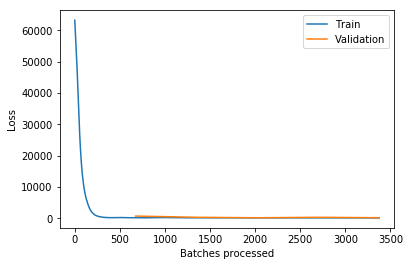

In [97]:
# %load ivanocode/pipeline/pipeline.py 
from ivanocode.pipeline.wrmsse import wrmsse_total, with_aggregate_series
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib

raw = 'raw'
processed = 'processed'
submissions = 'submissions'
tmp = 'tmp'

n_days_total = 1913
trn_days = 1900
n_total_series = 30490
n_sample_series = 500

from joblib import Memory
location = './tmp'
memory = Memory(location, verbose=1)

@memory.cache
def read_series_sample(n = 10):
    sample_idx = set(np.random.choice(
        range(1, n + 1),
        n
    ))

    # header
    sample_idx.add(0)

    return pd.read_csv(f'{raw}/sales_train_validation.csv', skiprows = lambda i: i not in sample_idx)

@memory.cache
def melt_sales_series(df_sales_train):
    id_columns = [col for col in df_sales_train.columns if 'id' in col]
    sales_columns = [col for col in df_sales_train.columns if 'd_' in col]
    cat_columns = [col for col in id_columns if col != 'id']

    df_sales_train_melt = df_sales_train.melt(
        id_vars=id_columns,
        var_name='day_id',
        value_name='sales'
    )

    for col in id_columns:
        df_sales_train_melt[col] = df_sales_train_melt[col].astype('category')

    df_sales_train_melt['sales'] = df_sales_train_melt['sales'].astype('int16')

    return df_sales_train_melt

@memory.cache
def extract_day_ids(df_sales_train_melt):
    sales_columns = [f'd_{col}' for col in range(1, n_days_total+1)]
    mapping = {col: int(col.split('_')[1]) for col in sales_columns}
    df_sales_train_melt['day_id'] = df_sales_train_melt['day_id'].map(mapping)

    import datetime
    d_1_date = pd.to_datetime('2011-01-29')
    mapping = {day:(d_1_date + datetime.timedelta(days=day-1)) for day in range(1, n_days_total+1)}
    df_sales_train_melt['day_date'] = df_sales_train_melt['day_id'].map(mapping)

    mapping = {day:str((d_1_date + datetime.timedelta(days=day-1)).date()) for day in range(1, n_days_total+1)}
    # gonna need it for joining with calendars & stuff
    df_sales_train_melt['day_date_str'] = df_sales_train_melt['day_id'].map(mapping)

    df_sales_train_melt['day_date_str'] = df_sales_train_melt['day_date_str'].astype('category')
    df_sales_train_melt['day_id'] = df_sales_train_melt['day_id'].astype('int16')
    df_sales_train_melt['month_id'] = df_sales_train_melt['day_date'].dt.month.astype('uint8')

    return df_sales_train_melt

@memory.cache
def join_w_calendar(df_sales_train_melt):
    df_calendar = pd.read_csv(f'{raw}/calendar.csv')
    df_sales_train_melt =  df_sales_train_melt.merge(
        df_calendar[['date', 'wm_yr_wk']],
        left_on='day_date_str', right_on='date',
        validate='many_to_one')

    df_sales_train_melt['wm_yr_wk'] = df_sales_train_melt['wm_yr_wk'].astype('int16')
    return df_sales_train_melt

@memory.cache
def join_w_prices(partition):
    df_prices = pd.read_csv(f'{raw}/sell_prices.csv')
    partition = partition.merge(
        df_prices,
        on=['store_id', 'item_id', 'wm_yr_wk'],
        how='left'
    )
    partition['sell_price'] = partition['sell_price'].astype('float32')
    partition['sales_dollars'] = (partition['sales'] * partition['sell_price']).astype('float32')
    partition.fillna({'sales_dollars': 0}, inplace=True)
    return partition

from fastai.tabular import *
from IPython.display import display


def _wrmsse(y, val, trn):
    pred = val.copy()
    pred['sales_dollars'] = y
    # TODO: rounding differently might be important for sporadic sales on lower-volume items
    pred['sales'] = pred['sales_dollars'] / pred['sell_price']
    pred['sales'].fillna(0, inplace=True)
    pred['sales'] = pred['sales'].astype('int')
    val_w_aggs = with_aggregate_series(val.copy())
    trn_w_aggs = with_aggregate_series(trn.copy())
    pred_w_aggs = with_aggregate_series(pred.copy())
    score = wrmsse_total(
        trn_w_aggs,
        val_w_aggs,
        pred_w_aggs
    )
    return score

from fastai.callbacks import *
# mega workaroundish way of plugging a metric func designed to work with all the data to run after each epoch 
# fast.ai is designed around per batch metrics + aggregating them
class MyMetrics(LearnerCallback):
    # should run before the recorder
    _order = -30
    def __init__(self, learn, trn, val):
        super().__init__(learn)
        self.trn = trn
        self.val = val
        self.learn = learn

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['wrmsse'])
        pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        # TODO: collect progress for a single val batch and make it available for display
        # display(pd.DataFrame({'y_pred': y, 'y_val': val['sales_dollars']}).transpose())
        rec = self.learn.recorder
        preds, y_val = self.learn.get_preds(DatasetType.Valid)
        y_pred = preds.numpy().flatten()
        self.learn.recorder = rec
        score = _wrmsse(y_pred, self.val, self.trn)
        return {'last_metrics': last_metrics + [score]}
    
class SingleBatchProgressTracker(LearnerCallback):
    # should run before the recorder
    _order = -31
    def __init__(self, learn, metric, metric_name):
        self.learn = learn
        self.batch = learn.data.one_batch(DatasetType.Train)
        self.x = self.batch[0]
        self.y_true = self.batch[1]
        self.metric = metric
        self.metric_name = metric_name
        
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names([self.metric_name])
        pass
        
    def on_epoch_end(self, last_metrics, **kwargs):
        y_model = self.learn.model.forward(*self.x)
        score = self.metric(self.y_true, y_model)
        return {'last_metrics': last_metrics + [score]}

def model_as_tabular(df_sales_train_melt, lr_find=False):
    non_zero = df_sales_train_melt.query('sales_dollars > 0').reset_index(drop=True)
    valid_idx = np.flatnonzero(non_zero['day_id'] > trn_days)

    # TODO: this in fact is rather fragile and won't work without reset index above, can I do this differently?
    val_mask = non_zero.index.isin(valid_idx)
    val = non_zero[val_mask]
    trn = non_zero[~val_mask]
    print(f"sample: {len(df_sales_train_melt)} non_zero: {len(non_zero)} trn: {len(trn)} val: {len(val)}")

    my_metrics_cb = partial(MyMetrics, val=val, trn=trn)
    single_batch_metric = partial(SingleBatchProgressTracker, metric=rmse, metric_name='example_batch_rmse')

    procs = [FillMissing, Categorify, Normalize]
    dep_var = 'sales_dollars'
    cat_names = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month_id', 'id']
    cols = cat_names + ['sell_price'] + [dep_var]

    path ='./tmp'
    data = TabularDataBunch.from_df(path, non_zero[cols], dep_var, valid_idx=valid_idx,
                                    bs=256,
                                    procs=procs, cat_names=cat_names)

    sales_range = df_sales_train_melt.agg({dep_var: ['min', 'max']})
    learn = tabular_learner(data, layers=[200,200,20,20], emb_szs=None, metrics=[rmse], 
                        y_range=sales_range[dep_var].values, callback_fns=[
                            my_metrics_cb, 
                            single_batch_metric],
                        use_bn=True,
                        wd=0)
    # Note to self: default wd seem to big - results converged to basically nothing in the first ep
    if lr_find:
        learn.lr_find()
        fig = learn.recorder.plot(return_fig=True)
        fig.savefig('lr_find.png')
        !open lr_find.png
    learn.fit_one_cycle(5, 1e-1)
    fig = learn.recorder.plot_losses(return_fig=True)
    fig.savefig('loss_log.png')

    """
    the above is pretty unstable, still we sort of got it to overfit slightly
    epoch     train_loss  valid_loss  root_mean_squared_error  time    
    0         83.365913   53.201424   7.188121                 00:00                                                                                      
    1         56.507870   55.011505   7.313859                 00:00                                                                                      
    2         48.014706   55.011673   7.313872                 00:00                                                                                      
    3         44.242149   55.001785   7.313148                 00:00                                                                                      
    4         42.347946   57.570885   7.462979                 00:00 
    epoch     train_loss  valid_loss  root_mean_squared_error  time    
    0         99.312691   88.176826   9.289624                 00:00                                                                                      
    1         53.812771   45.480507   6.625162                 00:00                                                                                      
    2         35.418938   19.952007   4.353195                 00:00                                                                                      
    3         23.099392   17.516432   4.008787                 00:00                                                                                      
    4         17.082275   17.641117   4.019526                 00:00 
    """
    return learn, trn, val

sales_series = read_series_sample(n_sample_series)
sales_series = melt_sales_series(sales_series)
sales_series = extract_day_ids(sales_series)
sales_series = join_w_calendar(sales_series)
sales_series = join_w_prices(sales_series)
learn, trn, val = model_as_tabular(sales_series)

In [49]:
from fastai.tabular import *

In [4]:
preds, y_trn2 = learn.get_preds(DatasetType.Train)

In [5]:
(cat_x, float_x), y_true = learn.data.one_batch(DatasetType.Train)

In [6]:
y_model = learn.model(cat_x, float_x)

In [7]:
rmse(y_true, learn.model(cat_x, float_x))

tensor(8.6365, grad_fn=<SqrtBackward>)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


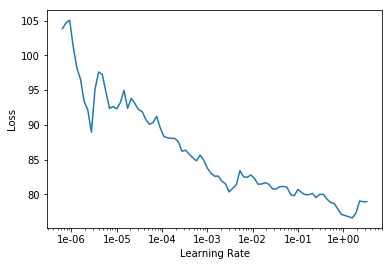

In [8]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.model.training

False

In [10]:
rmse(y_true, learn.model(cat_x, float_x))

tensor(8.6365, grad_fn=<SqrtBackward>)

In [11]:
len(preds.abs().flatten().numpy()), len(y_trn), len(trn['sales_dollars']),len(val['sales_dollars']),\
len(trn['sales_dollars'])-len(y_trn)

NameError: name 'y_trn' is not defined

In [ ]:
y_pred = preds.abs().flatten().numpy()

In [ ]:
pd.DataFrame({'y_pred': y_pred,
              'y_true_dl': y_trn,
              'y_true_dl2': y_trn2,
              'y_trn': trn['sales_dollars'][:len(y_pred)]})             

In [ ]:
tabular_learner??

In [ ]:
(trn['sales_dollars'] == 0).sum() / float(len(trn))

In [ ]:
(val['sales_dollars'] == 0).sum() / float(len(val))

In [ ]:
trn['sales_dollars'].hist()

In [ ]:
val['sales_dollars'].hist()

In [ ]:
"""
149.428452	141.160263	11.881088	0	00:03
1	92.145798	141.160294	11.881089	0	00:02
2	83.048798	141.160248	11.881088	0	00:02
3	82.048836	141.160294	11.881089	0	00:02
4	81.270966	141.160294	11.881089	0	00:02

# preds don't seem to change with reruns
tensor([13.9200,  1.9200,  1.4400,  5.9400,  8.3800, 32.4800,  0.9600,  8.3800,
         9.2800,  0.4800,  5.9400])
"""
val['id'].value_counts().sort_index()

In [ ]:
trn['id'].value_counts().sort_index()

In [ ]:
pd.read_csv(f'{raw}/calendar.csv', nrows=1)

In [ ]:
val

In [ ]:
# Karpathy's process for DNN end-to-end skeleton setup
# 0. Fix random seed
# 1. Simplify (e.g. no augmentations other unnecessary features)
# 2. When plotting the loss - run it over entire dataset
# 3. Verify loss @ {{c1::init}}
# 4. Init well
# 5. Human baseline
# 6. Input-independent baseline
# 7. Overfit {{c2::one batch}}
# 8. Verify decreasing training loss
# 9. Visualize what's fed into {{c3::the neural part of the model (stats after normalization etc)}}
# 10. Visualize prediction dynamics on {{c4::a single batch over the entire training}}
# 11. Use backprop to chart dependencies: {{c1::set loss for example to be 1, run backprop on it and make sure you get non-zero gradient on just that example}}
# 12. Start from a special case then generalize